# Jane Street - NN
This notebook trains a shallow neural network to classify the sign of the response based on features 0 - 129.

In [1]:
import joblib
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, PrecisionAtRecall
from tensorflow.keras.optimizers import Adam

# set tensorflow's random seed
tf.random.set_seed(13)

Read the data and extract the features and target variables. Then impute any missing values with the median over that feature.

In [2]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
full_df = pd.read_csv(file, engine="c", dtype=dtype)

# split into training and validation
train_df = full_df[full_df["date"].between(0, 400)]
valid_df = full_df[full_df["date"].between(425, 500)]

# build features and labels
features = [f"feature_{x}" for x in range(130)]
train_X = train_df[features].to_numpy()
valid_X = valid_df[features].to_numpy()
train_y = train_df["resp"].gt(0.0).astype(np.float32).to_numpy()
valid_y = valid_df["resp"].gt(0.0).astype(np.float32).to_numpy()

# replace missing values by median 
pp = SimpleImputer(strategy="median")
train_X = pp.fit_transform(train_X)
valid_X = pp.transform(valid_X)

Define and train the network. We use one dense hidden layer with a swish activation function and strong dropout regularization. We optimize the probabilistic loss using the Adam algorithm and stop training early when the validation AUC has not improved for 10 epochs.

In [3]:
# input & normalization
norm = layers.experimental.preprocessing.Normalization()
norm.adapt(train_X)
inputs = layers.Input(shape=[len(features)])
flow = norm(inputs)

# dense hidden layer
flow = layers.Dense(units=70)(flow)
flow = layers.Activation(keras.activations.swish)(flow)
flow = layers.Dropout(rate=0.5)(flow)

# output
flow = layers.Dense(units=1)(flow)
outputs = layers.Activation("sigmoid")(flow)

# optimization parameters
loss = BinaryCrossentropy()
optimizer = Adam(learning_rate=1e-3)
metrics = [PrecisionAtRecall(recall=0.55, name="p@r"), AUC(name="auc")]

# compile the model and print a summary
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

# define callback for early stopping
stopping = EarlyStopping(monitor="val_loss",
                         patience=10,
                         min_delta=1e-5,
                         restore_best_weights=True)

# fit the model
hist = model.fit(train_X, train_y,
                 epochs=200,
                 batch_size=512,
                 validation_data=(valid_X, valid_y),
                 callbacks=[stopping])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
normalization (Normalization (None, 130)               261       
_________________________________________________________________
dense (Dense)                (None, 70)                9170      
_________________________________________________________________
activation (Activation)      (None, 70)                0         
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0     

Show how the loss function and metrics evolved during training.

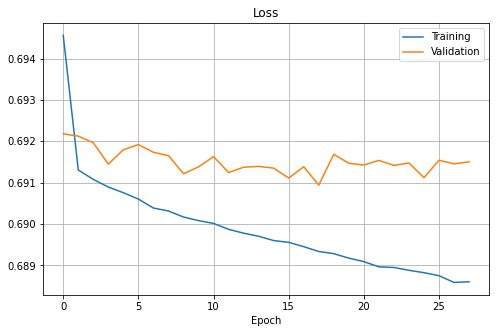

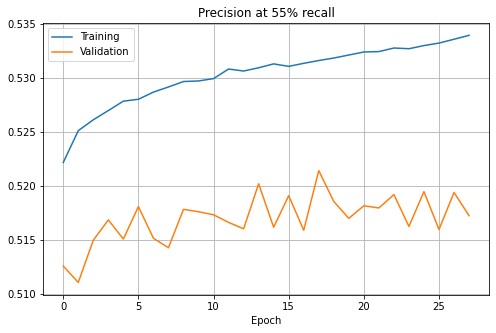

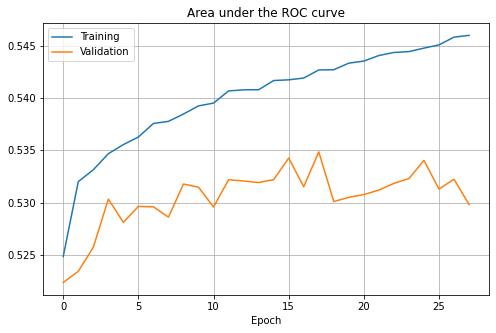

In [4]:
hist_df = pd.DataFrame(hist.history)

# loss
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["loss"], label="Training")
sns.lineplot(data=hist_df["val_loss"], label="Validation")
plt.title("Loss")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# precision at recall
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["p@r"], label="Training")
sns.lineplot(data=hist_df["val_p@r"], label="Validation")
plt.title(f"Precision at 55% recall")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# area under ROC curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["auc"], label="Training")
sns.lineplot(data=hist_df["val_auc"], label="Validation")
plt.title("Area under the ROC curve")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

Plot some performance metrics for the resulting classifier on the validation set.

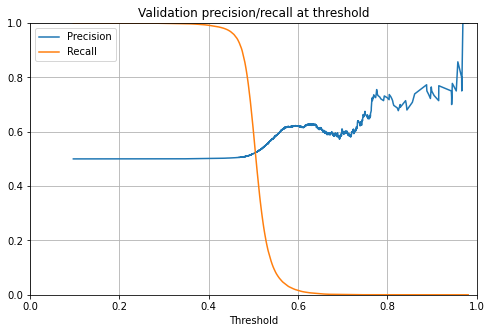

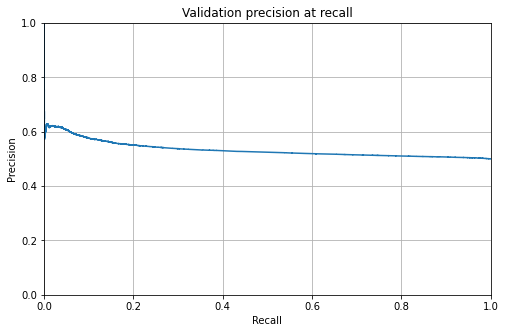

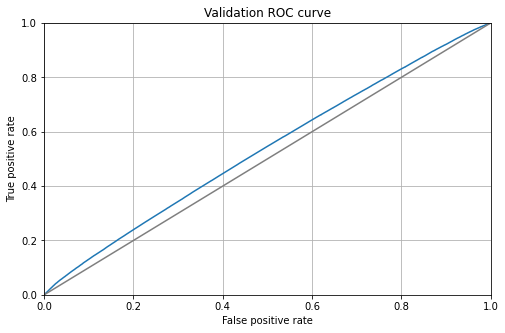

Validation AUC: 0.5349044705672354


In [5]:
probs = model.predict(valid_X)

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Validation precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Validation ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Validation AUC: {roc_auc_score(valid_y, probs)}")

Plot the same metrics on the training data to get an idea of how much overfitting occured.

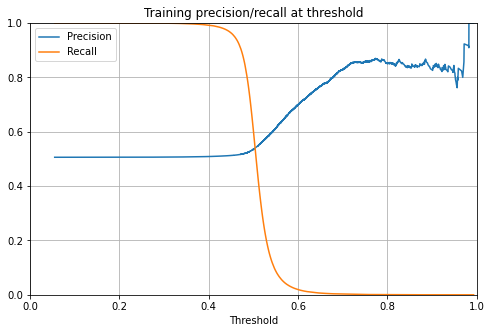

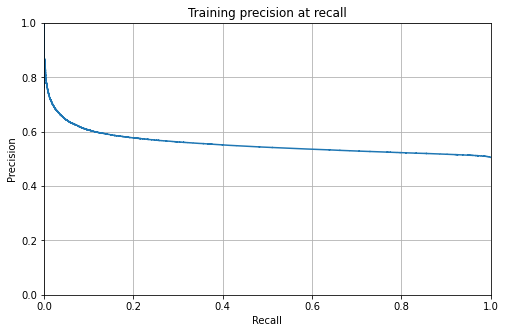

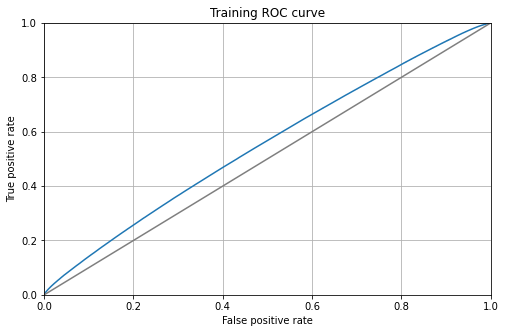

Training AUC: 0.5514234514510219


In [6]:
probs = model.predict(train_X)

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(train_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Training precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Training precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(train_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Training ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Training AUC: {roc_auc_score(train_y, probs)}")

Save the model and the preprocessing pipeline.

In [7]:
joblib.dump(pp, "preprocessor.pkl")

with open("model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("model.h5")